In [1]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [2]:
import tensorflow as tf
import numpy as np
import flowpm
from numpy.testing import assert_allclose
from scipy.interpolate import InterpolatedUnivariateSpline as iuspline
from flowpm import linear_field, lpt_init, nbody, cic_paint
#from pmesh.pm import ParticleMesh
import flowpm.tfpm as tfpm
import flowpm.utils as pmutils

%pylab inline

np.random.seed(0)

bs = 64
nc = 64

klin = np.loadtxt('../data/Planck15_a1p00.txt').T[0]
plin = np.loadtxt('../data/Planck15_a1p00.txt').T[1]
ipklin = iuspline(klin, plin)

Populating the interactive namespace from numpy and matplotlib


In [3]:
initial_conditions = flowpm.linear_field(nc, bs, ipklin, batch_size=1)

with tf.Session() as sess:
    linear_true = sess.run((initial_conditions))

In [4]:
import numpy as np
import numpy


def _initialize_pk(shape,boxsize,kmin,dk):
    """
       Helper function to initialize various (fixed) values for powerspectra... not differentiable!
    """
    I = np.eye(len(shape), dtype='int') * -2 + 1

    W = np.empty(shape, dtype='f4')
    W[...] = 2.0
    W[..., 0] = 1.0
    W[..., -1] = 1.0
    kedges = np.arange(kmin, np.pi * 3 / 2 + dk/2, dk)

    k = [np.fft.fftfreq(N, 1. / (N * 2 * np.pi / L))[:pkshape].reshape(kshape) for N, L, kshape, pkshape in zip(shape.as_list(), boxsize, I, shape.as_list())]
    kmag = sum(ki ** 2 for ki in k) ** 0.5

    xsum = np.zeros(len(kedges) + 1)
    Nsum = np.zeros(len(kedges) + 1)

    dig = np.digitize(kmag.flat, kedges)

    print(dig.size,xsum.size,len((W * kmag).flat))
    xsum.flat += np.bincount(dig, weights=(W * kmag).flat, minlength=xsum.size)
    Nsum.flat += np.bincount(dig, weights=W.flat, minlength=xsum.size)
    dig = tf.convert_to_tensor(dig,dtype=tf.int32)
    Nsum = tf.convert_to_tensor(Nsum,dtype=tf.complex64)
    xsum = tf.convert_to_tensor(np.array(xsum))
    W = tf.convert_to_tensor(np.array(W))
    k = np.array(k)
    kedges = tf.convert_to_tensor(np.array(kedges))
    return dig, Nsum, xsum, W, k, kedges


def pk(field,kmin=5,dk=0.8,shape = False,boxsize= False):   
    """
    Calculate the powerspectra given real space field
    
    Args:
        
        field: real valued field 
        kmin: minimum k-value for binned powerspectra
        dk: differential in each kbin
        shape: shape of field to calculate field (can be strangely shaped?)
        boxsize: length of each boxlength (can be strangly shaped?)
    
    Returns:
        
        kbins: the central value of the bins for plotting
        power: real valued array of power in each bin
        
    """
    
    print(field.shape)
    #initialze values related to powerspectra
    dig, Nsum, xsum, W, k, kedges = _initialize_pk(shape,boxsize,kmin,dk)
    
    
    #convert field to complex for fft
    field_complex = tf.dtypes.cast(field,dtype=tf.complex64)

    #fast fourier transform
    fft_image = tf.signal.fft3d(field_complex)
    
    #absolute value of fast fourier transform
    pk = tf.math.real(fft_image*tf.math.conj(fft_image))
    #calculating powerspectra
    Psum = tf.zeros(tf.size(kedges) + 1, dtype=tf.complex64)
    real = tf.reshape(tf.math.real(pk),[-1,])
    imag = tf.reshape(tf.math.imag(pk),[-1,])
    
    Psum  += tf.dtypes.cast(tf.math.bincount(dig, weights=(tf.reshape(W,[-1])  * imag), minlength=tf.size(xsum)),dtype=tf.complex64)*1j
    Psum  += tf.dtypes.cast(tf.math.bincount(dig, weights=(tf.reshape(W,[-1]) * real), minlength=tf.size(xsum)),dtype=tf.complex64)
    #print(W.flatten()  * imag,Psum)

    power = (Psum / Nsum)[1:-1] * boxsize.prod() 
    
    #normalization for powerspectra
    norm = tf.dtypes.cast(tf.reduce_prod(shape),dtype=tf.float32)**2
    
    #find central values of each bin
    kbins = kedges[:-1]+ (kedges[1:] - kedges[:-1])/2
    
    return kbins,tf.dtypes.cast(power,dtype=tf.float32)/norm


In [5]:
stages = np.linspace(0.1, 0.3, 1, endpoint=True) ## 0.3 when using lyman alpha forest
ic = tf.placeholder(tf.float32, [1, nc, nc,nc]) #Starting Point

# Sample particles
state = flowpm.lpt_init(ic, a0=0.1)   

# Evolve particles down to z=0
final_state = flowpm.nbody(state, stages, nc)         

# Retrieve final density field
final_field = flowpm.cic_paint(tf.zeros_like(ic), final_state[0])

pkr_ic = pk(tf.squeeze(ic,0),shape = final_field.shape[1:],  boxsize= np.array([bs,bs,bs]),kmin=0.001,dk=0.4)

pkr = pk(tf.squeeze(final_field,0),shape = final_field.shape[1:],  boxsize= np.array([bs,bs,bs]),kmin=0.001,dk=0.4)
        
with tf.Session() as sess:
    sim, pkr_ic0, pkr_out = sess.run((final_field,pkr_ic,pkr),{ic: linear_true})

(64, 64, 64)
262144 14 262144


D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


(64, 64, 64)
262144 14 262144


In [6]:
from flowpm.kernels import fftk

#setting up prior for model
kvec = fftk((nc, nc, nc), symmetric=False)
kmesh = sum((kk / bs * nc)**2 for kk in kvec)**0.5
pkmesh = ipklin(kmesh)

D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  """


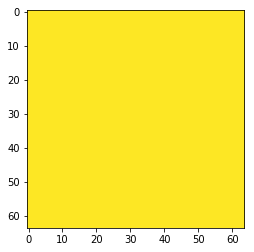

In [7]:
#variable noise... in this case masking the edges and including variable noise over image

a = numpy.arange(64)
numpy.random.shuffle(a)

noise_prop = np.ones((nc,nc,nc))*0.01
  
inv_sigma = (1/noise_prop)
plt.imshow(inv_sigma[0],vmin=0,vmax=20)

0.797116


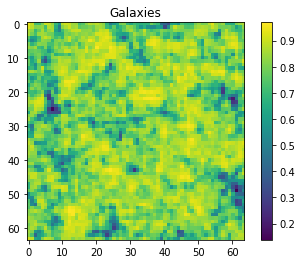

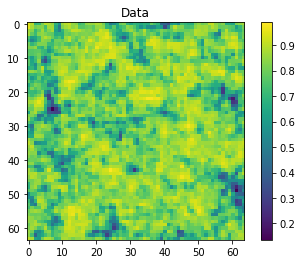

In [8]:
#True Bias Values...
b1=.22
b2=1.8

from scipy import ndimage
noise_real = np.random.randn(nc,nc,nc)*noise_prop#np.random.randn(1,32,32,32)*2
sims2 = sim#ndimage.gaussian_filter(sim,0.2,mode="wrap")
gal= np.exp(-b1*sims2**b2)
data = gal + noise_real

print(np.mean(gal))
title("Galaxies")
imshow(gal[0,4])
colorbar()
show()

title("Data")
imshow(data[0,4])
colorbar()


fgpa_flux = exp(-A*field**B) <- Hydrodynamical Lyman Alpha Flux

galax_bias = A*field + B**2*field**2 <- Bias for Galaxies



In [24]:
from tensorflow.contrib.opt import ScipyOptimizerInterface
import keras.backend as K
import flowpm

maxiter = 100
gtol=1e-12
sigma=1.0
tf.reset_default_graph()

def pm(lin,b):
  state = flowpm.lpt_init(lin, a0=0.1)
  final_state = flowpm.nbody(state, stages, nc)
  final_field = flowpm.cic_paint(tf.zeros_like(lin), final_state[0])
  return  final_field, tf.math.exp(-1*(0.20+b[0])*final_field**(b[1]+1.8))#(0.90+0.1*b[0])*final_field + (0.20+0.1*b[1])*final_field**2.0#tf.math.exp(-(0.22+b[0]*0.0001)*final_field**(1.8+b[1]*0.0001))


def likelihood_fn(inputs, b,predictions,inv_sigma = inv_sigma):
  """ Evaluates the data chi-squared function through Fast PM
  """
  _,final_field = pm(predictions[..., 0],b)

  clipped1 = final_field#K.clip(final_field,-25,10) #probably a bad idea!
  clipped2 = inputs[...,0]#K.clip(inputs[...,0],-25,10) #probably a bad idea!
  likelihood = tf.reduce_sum((clipped1-clipped2)**2*inv_sigma**2, 
                              axis=[1, 2, 3])
  
  return likelihood,final_field

def smoothing(field,Rsm,kmesh,nc):
    """ smoothing field in fourier space
    """
    
    Rsmsq = tf.multiply(Rsm, Rsm)
    smwts = tf.exp(tf.multiply(-kmesh**2, Rsmsq))

    #data = tf.squeeze(data)
    datak = tfpm.r2c3d(field, norm=nc**3)
    datak = tf.multiply(datak, tf.cast(smwts, tf.complex64))
    dataf = tfpm.c2r3d(datak, norm=nc**3)
    return dataf

xx = tf.placeholder(tf.float32, [1, nc, nc, nc]) #Starting Point
yy = tf.placeholder(tf.float32, [1, nc, nc, nc]) #Data

bias = tf.Variable([0.0,0.0], name="variables", trainable=True) #Bias

linearkk = tf.get_variable('linmesh', shape=(1, nc, nc, nc),
            initializer=tf.random_normal_initializer(mean=1.0, stddev=0.5), trainable=True)
initlin_op = linearkk.assign(xx, name='initlin_op')

linear_wc = tfpm.r2c3d(linearkk, norm=nc**3, name=None)
linear_k = tf.multiply(linear_wc, (pkmesh/bs**3)**0.5)
linear = tfpm.c2r3d(linear_k , norm=nc**3, name=None) #*1024*np.sqrt(2) 


#final = pm(linear,bias)

#Rs = tf.placeholder(tf.float64, shape = [1], name='smoothing')
#Rsm = tf.multiply(Rs, bs/nc)
#data_sm = smoothing(final,Rsm,kmesh,nc)


# Compute the likelihood fn
likelihood,final_field = likelihood_fn(tf.expand_dims(yy, -1), bias, tf.expand_dims(linear,-1)) 

# Compute the prior on field
#lineark = flowpm.utils.r2c3d(linear, norm=nc**3)
#priormesh = tf.square(tf.cast(tf.abs(lineark), tf.float32))
#prior_1 = tf.reduce_mean(tf.multiply(priormesh, 1./pkmesh**2))*nc**3

prior_1 = tf.cast(tf.square(tf.abs(linear_wc)), tf.float32)#tf.reduce_sum(tf.multiply(priormesh, 1/pkmesh**2))

# Compute the prior on the parameters (commented out for now!)
prior_values = tf.constant([0.0,0.000])
prior_2 = tf.reduce_sum((prior_values-bias)**2.0) #rough gaussian prior...

prior_total = tf.reduce_sum(prior_1)+prior_2

logposterior = tf.reduce_mean(likelihood) +  tf.reduce_mean(prior_total)

opt = ScipyOptimizerInterface(logposterior, var_list=[linearkk, bias], method='L-BFGS-B',
                                            options={'maxiter': maxiter, 'gtol':gtol})


In [25]:
from scipy import ndimage

starting_point = inp#np.random.randn(1,nc,nc,nc)

In [26]:
sess = tf.Session()    
sess.run(tf.global_variables_initializer())

batchsize = 1

# Initialize gradient descent at random point
sess.run(initlin_op, {xx: starting_point});

In [27]:
#for r in [0]:
st = time.time()
opt.minimize(sess, {yy:data[0:1]})
print("Total Time:", time.time()-st)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 3669613.250000
  Number of iterations: 12
  Number of functions evaluations: 21
Total Time: 9.548259019851685


In [28]:
test, inp, fins, bf = sess.run([linear,linearkk, final_field,bias], {xx:data[0:1],yy:data[0:1]})

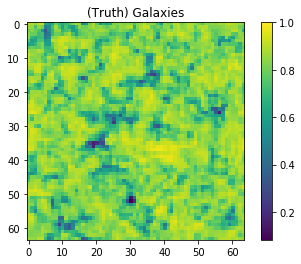

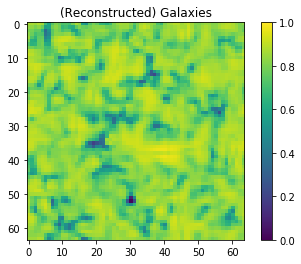

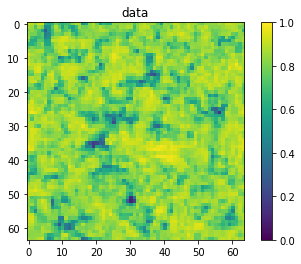

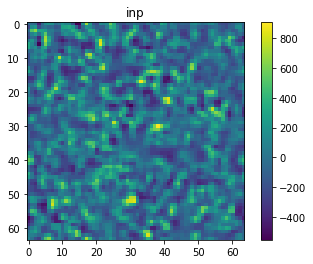

In [29]:

slic = 20

title("(Truth) Galaxies")
imshow(gal[0,slic],vmax=1)
colorbar()
show()

title("(Reconstructed) Galaxies")
imshow((fins[0][slic]),vmin = 0,vmax = 1)
#imshow((fins[0][0,slic]),vmin = 0,vmax = 1)
colorbar()
plt.show()

title("data")
imshow(data[0,slic],vmin = 0,vmax = 1)
colorbar()
show()

title("inp")
imshow(inp[0,slic])
colorbar()
show()


In [30]:
bf

array([ 0.0218548 , -0.08358786], dtype=float32)

In [31]:
def pk_func(inputs):
    nc = inputs.shape[1] #assume equal dimensions right now
    ic = tf.placeholder(tf.float32, [1, nc, nc, nc]) #Starting Point
    pkr = pk(tf.squeeze(ic,0),shape = ic.shape[1:],  boxsize= np.array([bs,bs,bs]),kmin=0.001,dk=0.4)
    with tf.Session() as sess:
        pk_out = sess.run((pkr),{ic: inputs})
    return pk_out

(64, 64, 64)
262144 14 262144


D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


[1.3178716e+03 2.4617265e+02 8.3064056e+01 3.7810421e+01 1.0933552e+01
 2.3135409e+00 4.4346419e-01 9.1305688e-02 1.6672596e-02 3.2756634e-03
 8.0248440e-04 2.0157837e-04]


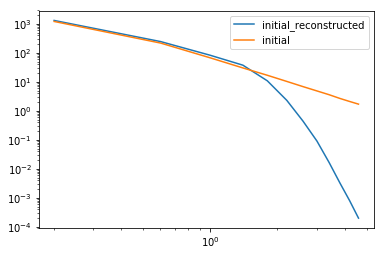

In [32]:
reconstructed_pk = pk_func(test)
plt.loglog(reconstructed_pk[0], reconstructed_pk[1], label = 'initial_reconstructed')
plt.loglog(pkr_ic0[0], pkr_ic0[1], label = 'initial')
legend()
print(reconstructed_pk[1])

In [33]:
reconstructed_pk[0].shape

(12,)

(64, 64, 64)
262144 14 262144


D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


[1.3178716e+03 2.4617281e+02 8.3064049e+01 3.7810432e+01 1.0933547e+01
 2.3135393e+00 4.4346365e-01 9.1305614e-02 1.6672600e-02 3.2756613e-03
 8.0248463e-04 2.0157843e-04]


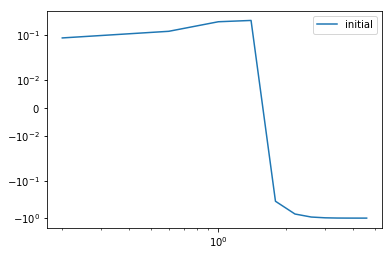

In [34]:
reconstructed_pk = pk_func(test)
#plt.loglog(reconstructed_pk[0], reconstructed_pk[1], label = 'initial_reconstructed')
plt.plot(pkr_ic0[0], (reconstructed_pk[1]-pkr_ic0[1])/pkr_ic0[1], label = 'initial')
semilogx()
plt.yscale('symlog', linthreshy=0.015)

legend()
print(reconstructed_pk[1])

In [35]:
delta = 0.06
modes = np.linspace(0.01, max(pkr_ic0[0]), reconstructed_pk[0].size)
#print(kmesh[31][31])
#print(max(kmesh[31][31]))

In [36]:
N = modes.size
filts = np.empty(shape=(N,), dtype=object)

for i in range(0, N, 1):
    filts[i] = np.logical_and(kmesh<modes[i]+delta,kmesh>modes[i]-delta)*2 + 1

fisher_matrix = np.zeros((N, N))

In [37]:
[np.sum(fili)-32**3 for fili in filts]

[229378,
 229844,
 231648,
 234500,
 237924,
 242916,
 249984,
 256068,
 258024,
 251904,
 243488,
 234420]

In [38]:
reconstructed_extra_power_fields= np.empty(shape=(N,), dtype=object)
true_extra_power_fields = np.empty(shape=(N,), dtype=object)

In [39]:
true_initial_mode_pks = np.empty(shape=(N,), dtype=object)
reconstructed_initial_mode_pks = np.empty(shape=(N,), dtype=object)
reconstructed_bf = np.empty(shape=(N,), dtype=object)

In [40]:
#initial_conditions = flowpm.linear_field(nc, bs, ipklin, batch_size=1)

#with tf.Session() as sess:
#    linear_true = sess.run((initial_conditions))
noise_real_mode = np.random.randn(nc,nc,nc)*noise_prop#np.random.randn(1,32,32,32)*2
 

maxiter = 300
gtol=1e-12
for i in range(0, N, 1):
    st = time.time()
    ic = tf.placeholder(tf.float32, [1, nc, nc,nc]) #Starting Point

    #apply transfer function to intial conditions

    #function will be gaussian smoothing

    Rs = tf.placeholder(tf.float64, shape = [1], name='filter')
    #Rsm = tf.multiply(Rs, bs/nc)
    #Rsmsq = tf.multiply(Rsm, Rsm)
    #smwts = tf.multiply(kmesh, Rsmsq) #transfer func calculated

    smwts = filts[i]
    datak = tfpm.r2c3d(ic, norm=nc**3)
    datak = tf.multiply(datak, tf.cast(smwts, tf.complex64))
    dataf = tfpm.c2r3d(datak, norm=nc**3)

    # Sample particles
    state = flowpm.lpt_init(dataf, a0=0.1)   

    # Evolve particles down to z=0
    final_state = flowpm.nbody(state, stages, nc)         

    # Retrieve final density field
    final_field = flowpm.cic_paint(tf.zeros_like(dataf), final_state[0])
    pkr_ic = pk(tf.squeeze(dataf,0),shape = final_field.shape[1:],  boxsize= np.array([bs,bs,bs]),kmin=0.001,dk=0.4) #0.001, 0.05

    pkr = pk(tf.squeeze(final_field,0),shape = final_field.shape[1:],  boxsize= np.array([bs,bs,bs]),kmin=0.001,dk=0.4) #0.05
        
    with tf.Session() as sess:
        sim_mode, pkr_ic_mode, pkr_out_mode = sess.run((final_field,pkr_ic,pkr),{ic: linear_true, Rs: [0.00]})

    true_extra_power_fields[i] = linear_true
    true_initial_mode_pks[i] = pkr_ic_mode
    
    #variable noise... in this case masking the edges and including variable noise over image
    a = numpy.arange(64)
    numpy.random.shuffle(a)
    inv_sigma = (1/noise_prop)
    
 #   noise_real_mode = np.random.randn(nc,nc,nc)*noise_prop#np.random.randn(1,32,32,32)*2
    sims2_mode = sim_mode#ndimage.gaussian_filter(sim,0.2,mode="wrap")
    gal_mode= np.exp(-1*b1*sims2_mode**b2)#b1*sims2_mode + b2*sims2_mode**2.0
    data_mode = gal_mode + noise_real_mode
    
    tf.reset_default_graph()

    xx = tf.placeholder(tf.float32, [1, nc, nc, nc]) #Starting Point
    yy = tf.placeholder(tf.float32, [1, nc, nc, nc]) #Data

    bias = tf.Variable([0.0,0.], name="variables", trainable=False) #Bias

    linearkk = tf.get_variable('linmesh', shape=(1, nc, nc, nc),
                initializer=tf.random_normal_initializer(mean=1.0, stddev=0.5), trainable=True)

    initlin_op = linearkk.assign(xx, name='initlin_op')

    linear_wc = tfpm.r2c3d(linearkk, norm=nc**3, name=None)
    linear_k = tf.multiply(linear_wc, (pkmesh/bs**3)**0.5)
    linear = tfpm.c2r3d(linear_k , norm=nc**3, name=None) #*1024*np.sqrt(2) 

    # Compute the prior on field
    prior_1 = tf.cast(tf.square(tf.abs(linear_wc)), tf.float32)#tf.reduce_sum(tf.multiply(priormesh, 1/pkmesh**2))

    # Compute the prior on the parametrers

    prior_values = tf.constant([0.0,0.0])

    prior_2 = tf.reduce_sum((prior_values-bias)**2.0) #rough gaussian prior... could probably remove/reduce random factor...

    prior_total = tf.reduce_sum(prior_1)+prior_2

    
    # Compute the likelihood fn
    likelihood, final = likelihood_fn(tf.expand_dims(yy, -1), bias, tf.expand_dims(linear,-1)) 

    logposterior = tf.reduce_sum(likelihood) +  tf.reduce_mean(prior_total)

    
    ######## LOOP 1: Just optimize density field
    
    opt = ScipyOptimizerInterface(logposterior, var_list=[linearkk], method='L-BFGS-B',
                                                options={'maxiter': maxiter, 'gtol':gtol})
    
    starting_point = inp#np.random.randn(1,nc, nc, nc)*100#inp/10+

    sess = tf.Session()    
    sess.run(tf.global_variables_initializer())
    
    batchsize = 1
    
    # Initialize gradient descent at random point
    sess.run(initlin_op, {xx: starting_point});
    
    opt.minimize(sess, {xx:starting_point, yy:data_mode[0:1]})
    
    inp_i, test_mode, fins_mode,bff= sess.run([linearkk,linear, final,bias], {xx:data[0:1],yy:data_mode[0:1]})
    
    ###### LOOP 2: Optimized Density field + Bias Parameters
    
    opt = ScipyOptimizerInterface(logposterior, var_list=[linearkk,bias], method='L-BFGS-B',
                                                options={'maxiter': maxiter, 'gtol':gtol})
    
    starting_point = inp_i #starting from best fit part of LOOP 1

    sess = tf.Session()    
    sess.run(tf.global_variables_initializer())
    
    batchsize = 1
    
    # Initialize...
    sess.run(initlin_op, {xx: starting_point});
    
    opt.minimize(sess, {xx:starting_point, yy:data_mode[0:1]})
    
    inp_i, test_mode, fins_mode,bff= sess.run([linearkk,linear, final,bias], {xx:data[0:1],yy:data_mode[0:1]})
    
    print(bff)
    #########
    
    reconstructed_pk_mode = pk_func(test_mode)
    
    reconstructed_initial_mode_pks[i] = reconstructed_pk_mode
    reconstructed_bf[i] = bff
    
    fisher_entry = (reconstructed_pk_mode[1] - reconstructed_pk[1])
    
    fisher_matrix[:,i] = fisher_entry
    
    print(i,time.time()-st)
   # saved_fields[i] = test_mode
    
np.save('initial_reconstructed_w_extra_power_pks5', reconstructed_initial_mode_pks)
np.save('initial_true_w_extra_power_pks5', true_initial_mode_pks)
np.save('linear_reconstructed_w_extra_power_fields5', reconstructed_extra_power_fields)
np.save('linear_true_w_extra_power_fields5', true_extra_power_fields)




(64, 64, 64)
262144 14 262144
(64, 64, 64)
262144 14 262144


D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 1416372.500000
  Number of iterations: 301
  Number of functions evaluations: 318
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 813612.125000
  Number of iterations: 13
  Number of functions evaluations: 23
[ 0.02051723 -0.0863051 ]
(64, 64, 64)
262144 14 262144


D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


0 90.71606850624084
(64, 64, 64)
262144 14 262144
(64, 64, 64)
262144 14 262144
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 1449860.250000
  Number of iterations: 301
  Number of functions evaluations: 317
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 912630.875000
  Number of iterations: 12
  Number of functions evaluations: 19
[ 0.01996204 -0.07759045]
(64, 64, 64)
262144 14 262144


D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


1 91.88453412055969
(64, 64, 64)
262144 14 262144
(64, 64, 64)
262144 14 262144
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 1526312.625000
  Number of iterations: 301
  Number of functions evaluations: 315
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 986881.500000
  Number of iterations: 12
  Number of functions evaluations: 19
[ 0.02013892 -0.0840029 ]
(64, 64, 64)
262144 14 262144


D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


2 93.97854804992676
(64, 64, 64)
262144 14 262144
(64, 64, 64)
262144 14 262144
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 1585957.875000
  Number of iterations: 301
  Number of functions evaluations: 313
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 1017693.125000
  Number of iterations: 13
  Number of functions evaluations: 20
[ 0.02048636 -0.08578971]
(64, 64, 64)
262144 14 262144


D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


3 94.5264961719513
(64, 64, 64)
262144 14 262144
(64, 64, 64)
262144 14 262144
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 1662608.500000
  Number of iterations: 301
  Number of functions evaluations: 315
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 1073135.875000
  Number of iterations: 14
  Number of functions evaluations: 26
[ 0.02045317 -0.0783847 ]
(64, 64, 64)
262144 14 262144


D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


4 97.35035991668701
(64, 64, 64)
262144 14 262144
(64, 64, 64)
262144 14 262144
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 1666271.125000
  Number of iterations: 301
  Number of functions evaluations: 317
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 1037588.875000
  Number of iterations: 13
  Number of functions evaluations: 22
[ 0.02088881 -0.07689813]
(64, 64, 64)
262144 14 262144


D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


5 97.49625539779663
(64, 64, 64)
262144 14 262144
(64, 64, 64)
262144 14 262144
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 1722491.250000
  Number of iterations: 301
  Number of functions evaluations: 314
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 1076737.500000
  Number of iterations: 13
  Number of functions evaluations: 26
[ 0.0210557  -0.07666308]
(64, 64, 64)
262144 14 262144


D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


6 100.70533156394958
(64, 64, 64)
262144 14 262144
(64, 64, 64)
262144 14 262144
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 1830673.000000
  Number of iterations: 301
  Number of functions evaluations: 314
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 1199942.500000
  Number of iterations: 13
  Number of functions evaluations: 25
[ 0.02095915 -0.08387911]
(64, 64, 64)
262144 14 262144


D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


7 98.71216654777527
(64, 64, 64)
262144 14 262144
(64, 64, 64)
262144 14 262144
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 1795775.375000
  Number of iterations: 301
  Number of functions evaluations: 313
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 1188009.750000
  Number of iterations: 14
  Number of functions evaluations: 29
[ 0.02068031 -0.08881532]
(64, 64, 64)
262144 14 262144


D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


8 102.718341588974
(64, 64, 64)
262144 14 262144
(64, 64, 64)
262144 14 262144
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 1599905.750000
  Number of iterations: 301
  Number of functions evaluations: 314
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 1002872.312500
  Number of iterations: 13
  Number of functions evaluations: 19
[ 0.02065486 -0.09627495]
(64, 64, 64)
262144 14 262144


D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


9 104.14337730407715
(64, 64, 64)
262144 14 262144
(64, 64, 64)
262144 14 262144
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 1481372.125000
  Number of iterations: 301
  Number of functions evaluations: 315
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 878195.750000
  Number of iterations: 13
  Number of functions evaluations: 30
[ 0.02067975 -0.09332909]
(64, 64, 64)
262144 14 262144


D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


10 102.4216616153717
(64, 64, 64)
262144 14 262144
(64, 64, 64)
262144 14 262144
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 1422312.875000
  Number of iterations: 301
  Number of functions evaluations: 317
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 822068.937500
  Number of iterations: 14
  Number of functions evaluations: 24
[ 0.02058143 -0.09084688]
(64, 64, 64)
262144 14 262144


D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


11 100.73530077934265


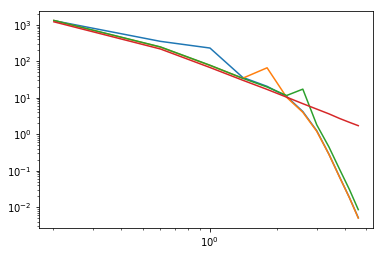

In [41]:
plt.loglog(reconstructed_initial_mode_pks[2][0],reconstructed_initial_mode_pks[2][1])
plt.loglog(reconstructed_initial_mode_pks[4][0],reconstructed_initial_mode_pks[4][1])
plt.loglog(reconstructed_initial_mode_pks[6][0],reconstructed_initial_mode_pks[6][1])
#plt.loglog(reconstructed_pk[0],  reconstructed_pk[1], label = 'initial_reconstructed')
plt.loglog(pkr_ic0[0], pkr_ic0[1], label = 'initial')

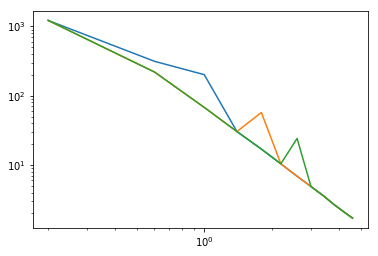

In [42]:
#Input modes, should look like little bumps

#true_initial_mode_pks[i]
plt.loglog(reconstructed_initial_mode_pks[2][0],true_initial_mode_pks[2][1])
plt.loglog(reconstructed_initial_mode_pks[4][0],true_initial_mode_pks[4][1])
plt.loglog(reconstructed_initial_mode_pks[6][0],true_initial_mode_pks[6][1])
#plt.loglog(reconstructed_pk[0],  reconstructed_pk[1], label = 'initial_reconstructed')
#plt.loglog(pkr_ic0[0], pkr_ic0[1], label = 'initial')

In [43]:
#calculating average reconstructed PS to reduce noise... could also just run the first part of the code a few dozen times...

pks = [reconstructed_initial_mode_pks[n][1] for n in range(0,12,2)]
pk_c = np.median(np.array(pks),axis = 0)


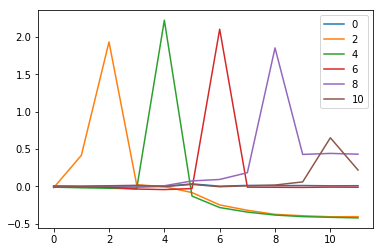

In [44]:
#response of little bumps

for i in range(0,12,2):
    plot(np.array(reconstructed_initial_mode_pks[i][1]-pk_c)[0:]/pk_c[0:],label=str(i))
legend()
#ylim(-5,5)


In [157]:
tf.reset_default_graph()

# Add variation to Bias Values
b1_new= b1 + delta
b2_new= b2 + delta


# calculating b1 variation response
noise_real = np.random.randn(nc,nc,nc)*noise_prop#np.random.randn(1,32,32,32)*2
sims2_new = sim#ndimage.gaussian_filter(sim,0.2,mode="wrap")
new_gal= np.exp(-b1_new*sims2_new**b2)
new_data = new_gal + noise_real

#print(np.mean(new_gal))
#title("Galaxies")
#imshow(new_gal[0,4])
#colorbar()
#show()

#title("Data")
#imshow(new_data[0,4])
#colorbar()

# Rerun the reconstruction with slightly varied bias parameters

maxiter = 300
gtol=1e-12
sigma=1.0

xx = tf.placeholder(tf.float32, [1, nc, nc, nc]) #Starting Point
yy = tf.placeholder(tf.float32, [1, nc, nc, nc]) #Data

bias = tf.Variable([0.0,0.0], name="variables", trainable=True) #Bias

linearkk = tf.get_variable('linmesh', shape=(1, nc, nc, nc),
            initializer=tf.random_normal_initializer(mean=1.0, stddev=0.5), trainable=True)
initlin_op = linearkk.assign(xx, name='initlin_op')

linear_wc = tfpm.r2c3d(linearkk, norm=nc**3, name=None)
linear_k = tf.multiply(linear_wc, (pkmesh/bs**3)**0.5)
linear = tfpm.c2r3d(linear_k , norm=nc**3, name=None) #*1024*np.sqrt(2) 


#final = pm(linear,bias)

#Rs = tf.placeholder(tf.float64, shape = [1], name='smoothing')
#Rsm = tf.multiply(Rs, bs/nc)
#data_sm = smoothing(final,Rsm,kmesh,nc)


# Compute the likelihood fn
likelihood,final_field = likelihood_fn(tf.expand_dims(yy, -1), bias, tf.expand_dims(linear,-1)) 

# Compute the prior on field
#lineark = flowpm.utils.r2c3d(linear, norm=nc**3)
#priormesh = tf.square(tf.cast(tf.abs(lineark), tf.float32))
#prior_1 = tf.reduce_mean(tf.multiply(priormesh, 1./pkmesh**2))*nc**3

prior_1 = tf.cast(tf.square(tf.abs(linear_wc)), tf.float32)#tf.reduce_sum(tf.multiply(priormesh, 1/pkmesh**2))

# Compute the prior on the parameters (commented out for now!)
prior_values = tf.constant([0.0,0.000])
prior_2 = tf.reduce_sum((prior_values-bias)**2.0) #rough gaussian prior...

prior_total = tf.reduce_sum(prior_1)+prior_2

logposterior = tf.reduce_mean(likelihood) +  tf.reduce_mean(prior_total)

opt = ScipyOptimizerInterface(logposterior, var_list=[linearkk, bias], method='L-BFGS-B',
                                            options={'maxiter': maxiter, 'gtol':gtol})

In [158]:
starting_point = inp#np.random.randn(1,nc,nc,nc)

In [159]:
sess = tf.Session()    
sess.run(tf.global_variables_initializer())

batchsize = 1

# Initialize gradient descent at random point
sess.run(initlin_op, {xx: starting_point});

In [160]:
#for r in [0]:
st = time.time()
opt.minimize(sess, {yy:new_data[0:1]})
print("Total Time:", time.time()-st)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 2707201.750000
  Number of iterations: 10
  Number of functions evaluations: 27
Total Time: 10.783974647521973


In [161]:
test1, inp, fins1, new_bf1 = sess.run([linear,linearkk, final_field,bias], {xx:data[0:1],yy:data[0:1]})

In [168]:
tf.reset_default_graph()

# calculating b2 variation response
noise_real = np.random.randn(nc,nc,nc)*noise_prop#np.random.randn(1,32,32,32)*2
sims2_new = sim#ndimage.gaussian_filter(sim,0.2,mode="wrap")
new_gal= np.exp(-b1*sims2_new**b2_new)
new_data = new_gal + noise_real

#print(np.mean(new_gal))
#title("Galaxies")
#imshow(new_gal[0,4])
#colorbar()
#show()

#title("Data")
#imshow(new_data[0,4])
#colorbar()

# Rerun the reconstruction with slightly varied bias parameters

maxiter = 300
gtol=1e-12
sigma=1.0

xx = tf.placeholder(tf.float32, [1, nc, nc, nc]) #Starting Point
yy = tf.placeholder(tf.float32, [1, nc, nc, nc]) #Data

bias = tf.Variable([0.0,0.0], name="variables", trainable=True) #Bias

linearkk = tf.get_variable('linmesh', shape=(1, nc, nc, nc),
            initializer=tf.random_normal_initializer(mean=1.0, stddev=0.5), trainable=True)
initlin_op = linearkk.assign(xx, name='initlin_op')

linear_wc = tfpm.r2c3d(linearkk, norm=nc**3, name=None)
linear_k = tf.multiply(linear_wc, (pkmesh/bs**3)**0.5)
linear = tfpm.c2r3d(linear_k , norm=nc**3, name=None) #*1024*np.sqrt(2) 


#final = pm(linear,bias)

#Rs = tf.placeholder(tf.float64, shape = [1], name='smoothing')
#Rsm = tf.multiply(Rs, bs/nc)
#data_sm = smoothing(final,Rsm,kmesh,nc)


# Compute the likelihood fn
likelihood,final_field = likelihood_fn(tf.expand_dims(yy, -1), bias, tf.expand_dims(linear,-1)) 

# Compute the prior on field
#lineark = flowpm.utils.r2c3d(linear, norm=nc**3)
#priormesh = tf.square(tf.cast(tf.abs(lineark), tf.float32))
#prior_1 = tf.reduce_mean(tf.multiply(priormesh, 1./pkmesh**2))*nc**3

prior_1 = tf.cast(tf.square(tf.abs(linear_wc)), tf.float32)#tf.reduce_sum(tf.multiply(priormesh, 1/pkmesh**2))

# Compute the prior on the parameters (commented out for now!)
prior_values = tf.constant([0.0,0.000])
prior_2 = tf.reduce_sum((prior_values-bias)**2.0) #rough gaussian prior...

prior_total = tf.reduce_sum(prior_1)+prior_2

logposterior = tf.reduce_mean(likelihood) +  tf.reduce_mean(prior_total)

opt = ScipyOptimizerInterface(logposterior, var_list=[linearkk, bias], method='L-BFGS-B',
                                            options={'maxiter': maxiter, 'gtol':gtol})

In [169]:
starting_point = inp#np.random.randn(1,nc,nc,nc)

In [170]:
sess = tf.Session()    
sess.run(tf.global_variables_initializer())

batchsize = 1

# Initialize gradient descent at random point
sess.run(initlin_op, {xx: starting_point});

In [171]:
#for r in [0]:
st = time.time()
opt.minimize(sess, {yy:new_data[0:1]})
print("Total Time:", time.time()-st)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 1406279.875000
  Number of iterations: 14
  Number of functions evaluations: 27
Total Time: 10.804932117462158


In [172]:
test2, inp, fins2, new_bf2 = sess.run([linear,linearkk, final_field,bias], {xx:data[0:1],yy:data[0:1]})

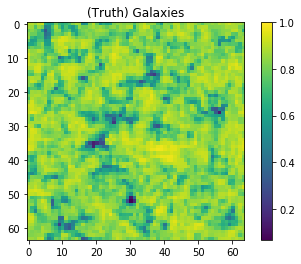

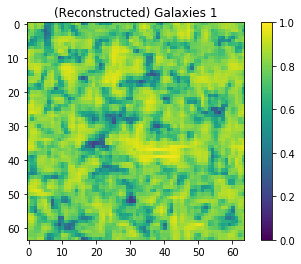

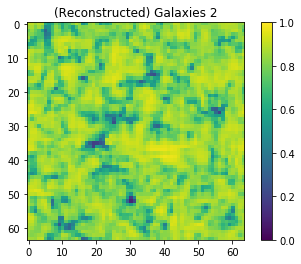

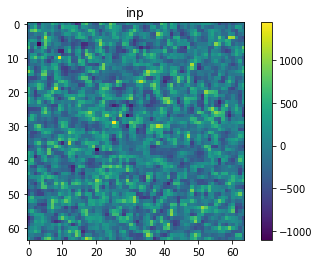

In [173]:
slic = 20

title("(Truth) Galaxies")
imshow(new_gal[0,slic],vmax=1)
colorbar()
show()

title("(Reconstructed) Galaxies 1")
imshow((fins1[0][slic]),vmin = 0,vmax = 1)
#imshow((fins[0][0,slic]),vmin = 0,vmax = 1)
colorbar()
plt.show()

title("(Reconstructed) Galaxies 2")
imshow((fins2[0][slic]),vmin = 0,vmax = 1)
#imshow((fins[0][0,slic]),vmin = 0,vmax = 1)
colorbar()
plt.show()

title("inp")
imshow(inp[0,slic])
colorbar()
show()


In [174]:
new_bf1, new_bf2

(array([ 0.08218714, -0.3272121 ], dtype=float32),
 array([ 0.02143792, -0.07800421], dtype=float32))

(64, 64, 64)
262144 14 262144


D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


[1.80701160e+03 3.83472534e+02 1.26575645e+02 5.61441498e+01
 2.93668842e+01 1.35508413e+01 4.58685446e+00 1.25935197e+00
 2.77446628e-01 6.17603548e-02 1.69518162e-02 4.60332632e-03]


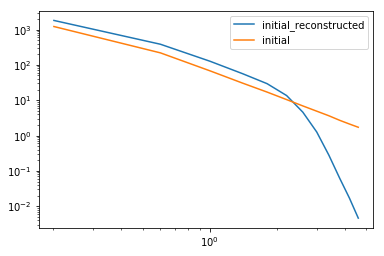

In [175]:
reconstructed_pk = pk_func(test1)
plt.loglog(reconstructed_pk[0], reconstructed_pk[1], label = 'initial_reconstructed')
plt.loglog(pkr_ic0[0], pkr_ic0[1], label = 'initial')
legend()
print(reconstructed_pk[1])

(64, 64, 64)
262144 14 262144


D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


[1.80701160e+03 3.83472534e+02 1.26575645e+02 5.61441498e+01
 2.93668842e+01 1.35508413e+01 4.58685446e+00 1.25935197e+00
 2.77446628e-01 6.17603548e-02 1.69518162e-02 4.60332632e-03]


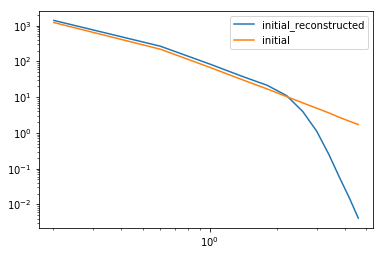

In [176]:
reconstructed_pk_2 = pk_func(test2)
plt.loglog(reconstructed_pk_2[0], reconstructed_pk_2[1], label = 'initial_reconstructed')
plt.loglog(pkr_ic0[0], pkr_ic0[1], label = 'initial')
legend()
print(reconstructed_pk[1])

In [177]:
bf

array([ 0.0218548 , -0.08358786], dtype=float32)

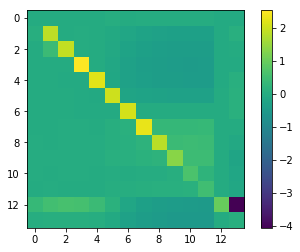

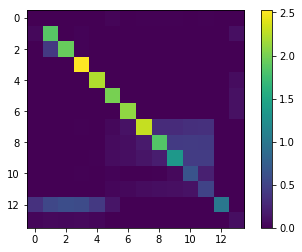

In [178]:
#recalculate the fisher matrix
for ii in range(0,N,1):
    fisher_matrix[ii] = np.array(reconstructed_initial_mode_pks[ii][1]-pk_c)[0:]/pk_c[0:]

expanded_fisher_matrix = np.zeros((N+2, N+2))
expanded_fisher_matrix[0:N, 0:N] = fisher_matrix

for i in range(0, N, 1):
    expanded_fisher_matrix[i, N:(N+2)] = np.array(reconstructed_bf[i] - bf)/delta

expanded_fisher_matrix[N, 0:N] = np.array(reconstructed_pk[1]-pk_c)[0:]/pk_c[0:]
expanded_fisher_matrix[N+1, 0:N] = np.array(reconstructed_pk_2[1]-pk_c)[0:]/pk_c[0:]

expanded_fisher_matrix[N, N:(N+2)] = np.array(new_bf1 - bf)/delta
expanded_fisher_matrix[N+1, N:(N+2)] = np.array(new_bf2 - bf)/delta


imshow(expanded_fisher_matrix[:,:])
colorbar()
show()
imshow(expanded_fisher_matrix[:,:], vmin = 0)
colorbar()

In [179]:
#imshow(fisher_matrix[:,:].T)
#colorbar()

In [180]:
#reconstructed_bf #should be ~[0.020,0.0], but small amount off is okay...

In [181]:
#inv_fs = np.linalg.inv(fisher_matrix[:,:])
inv_fs = np.linalg.inv(expanded_fisher_matrix[:,:])

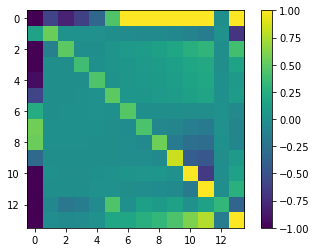

In [182]:
imshow(inv_fs,vmax=1,vmin=-1)
colorbar()
#inverse fisher matrix, should look mostly diagonal. First mode is very screwed up (don't worry about that...)

In [183]:
#ratio of marginalized error to unmarginalized error... should be >1.0

#np.sqrt(np.diag(inv_fs))/(1/np.sqrt(np.diag(fisher_matrix)[:]))
np.sqrt(np.diag(inv_fs))/(1/np.sqrt(np.diag(expanded_fisher_matrix)[:]))

D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


array([       nan, 1.01447694, 0.98075444, 0.99082812, 1.00008997,
       0.99999216, 0.99558686, 1.00041112, 1.01624625, 1.06290774,
       1.05823292, 1.11233649, 0.57296743, 0.4025007 ])

In [51]:
nb = (pkr_ic0[1]-pk_c)[0:]

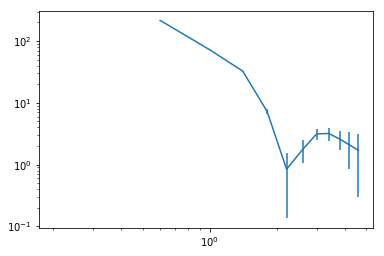

In [52]:
plt.errorbar(reconstructed_pk[0][1:], reconstructed_pk[1][1:] + nb[1:], yerr= 1/np.sqrt(np.diag(fisher_matrix)[1:]), label = 'initial_reconstructed')
plt.loglog(pkr_ic0[0], pkr_ic0[1]-pkr_ic0[1], label = 'initial')
#semilogy()



In [ ]:
plt.errorbar(reconstructed_pk[0][1:], reconstructed_pk[1][1:] - (reconstructed_initial_mode_pks[0][1][1:]-pkr_ic0[1][1:]), yerr= 1/np.sqrt(np.diag(fisher_matrix)[1:]), label = 'initial_reconstructed')
plt.loglog(pkr_ic0[0], pkr_ic0[1], label = 'initial')
semilogy()



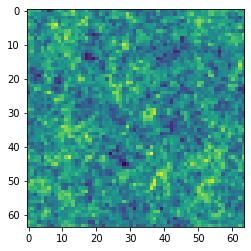

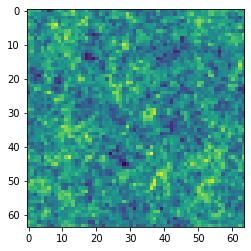

In [325]:
imshow(true_extra_power_fields[0][0][20])
show()
imshow(true_extra_power_fields[3][0][20])
